In [1]:
import os
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import importlib.resources as pkg_resources
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

import sesame as ssm

In [2]:
raw_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw/')
output_path = os.path.join(os.path.dirname(os.getcwd()),'data', 'output/')
plot_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'plot/')
netcdf_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'netcdf/')
atlas_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'atlas/')

# Pre-processing

In [3]:
def get_psut_io(raw_path, materials, year):
    
    # Load the flow and process code mappings
    flows_codes = pd.read_csv(os.path.join(raw_path, "Codes_Flows.csv"), delimiter=';', quotechar='"')
    process_codes = pd.read_csv(os.path.join(raw_path, "Codes_Processes.csv"), delimiter=';', quotechar='"')
    
    # Load the gPSUT supply (S) and use (U) tables for 2013
    psut_path = os.path.join(raw_path, "gPSUT", str(year))
    s_matrix = pd.read_csv(os.path.join(psut_path, "S.csv"), header=None)
    u_matrix = pd.read_csv(os.path.join(psut_path, "U.csv"), header=None)

    # Find their 0-based indices in the gPSUT matrices
    flow_idxs = (flows_codes.loc[flows_codes['FlowName'].isin(materials), 'Index'].values - 1).astype(int).tolist()
    
    # Sum across those flows for each process
    #  - total_supply: series indexed by process (row in S)
    #  - total_use:   series indexed by process (column in U)
    total_supply = s_matrix.iloc[:, flow_idxs].sum(axis=1)
    total_use    = u_matrix.iloc[flow_idxs, :].sum(axis=0)
    
    # Map each process to its country
    process_country = process_codes['RegionName']  # length matches number of processes

    # Aggregate to get country-level totals
    supply_by_country = total_supply.groupby(process_country).sum()
    use_by_country    = total_use.groupby(process_country).sum()

    # Build a proportional trade matrix (exports from i → imports by j)
    demand_share = use_by_country / use_by_country.sum()
    trade_matrix = np.outer(supply_by_country, demand_share)

    # Assemble into a DataFrame, in tonnes, rounded to two decimals
    country_list = supply_by_country.index.tolist()
    trade_df = pd.DataFrame(trade_matrix, index=country_list, columns=country_list).round(2)

    # Reshape a single-year matrix to long form
    df_long = (trade_df.reset_index().melt(id_vars='index', var_name='importer', value_name='tonnes').rename(columns={'index': 'exporter'}))
    df_long['year'] = year

    return df_long


In [4]:
year_list = list(range(2008, 2018, 1))
year_list

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [5]:
primary_iron = [
    'Iron ore',
    'Pig iron',
    'Sponge iron',
    'Steel scrap',
    'Forming scrap',
    'Fabrication scrap'
]
year_list = range(2008, 2018, 1)
io_path = raw_path + "PIOLab_gPIOTs_iron-steel_v1/"

dfs = []
year_list = list(range(2008, 2018, 1))

for year in year_list:
    df_y = get_psut_io(raw_path=io_path, materials=primary_iron, year=year)
    dfs.append(df_y)
    
df_io = pd.concat(dfs) 
df_io

,exporter,importer,tonnes,year
0,Australia,Australia,2248078.64,2008
1,Austria,Australia,65650.06,2008
2,Belgium,Australia,106390.55,2008
3,Brazil,Australia,2526052.65,2008
4,Canada,Australia,270216.51,2008
...,...,...,...,...
1019,Spain,United States,371861.37,2017
1020,Sweden,United States,1390212.90,2017
1021,Taiwan,United States,701278.24,2017
1022,United Kingdom,United States,660696.55,2017


In [6]:
df_io["exporter"].unique()

array(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'China',
       'Czech Republic', 'Finland', 'France', 'Germany', 'Greece',
       'India', 'Indonesia', 'Italy', 'Japan', 'Mexico', 'Netherlands',
       'Poland', 'RoW Africa', 'RoW America', 'RoW Asia and Pacific',
       'RoW EU27', 'RoW Europe', 'RoW Middle East', 'Russia', 'Slovakia',
       'South Korea', 'Spain', 'Sweden', 'Taiwan', 'United Kingdom',
       'United States'], dtype=object)

In [7]:
df_io["tonnes"].sum() * 1e-6

np.float64(38354.06748197)

In [8]:
df_io = ssm.add_iso3_column(df_io, "exporter")
# If ISO3 is missing, fill with original country name
df_io['ISO3'] = df_io['ISO3'].fillna(df_io['exporter'])
df_io = df_io.rename(columns={'ISO3': 'exp_ISO3'})
df_io = ssm.add_iso3_column(df_io, "importer")
# If ISO3 is missing, fill with original country name
df_io['ISO3'] = df_io['ISO3'].fillna(df_io['importer'])
df_io = df_io.rename(columns={'ISO3': 'imp_ISO3'})
df_io

Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']
Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']


,exporter,importer,tonnes,year,exp_ISO3,imp_ISO3
0,Australia,Australia,2248078.64,2008,AUS,AUS
1,Austria,Australia,65650.06,2008,AUT,AUS
2,Belgium,Australia,106390.55,2008,BEL,AUS
3,Brazil,Australia,2526052.65,2008,BRA,AUS
4,Canada,Australia,270216.51,2008,CAN,AUS
...,...,...,...,...,...,...
1019,Spain,United States,371861.37,2017,ESP,USA
1020,Sweden,United States,1390212.90,2017,SWE,USA
1021,Taiwan,United States,701278.24,2017,TWN,USA
1022,United Kingdom,United States,660696.55,2017,GBR,USA


In [9]:
df_io[df_io["importer"] == "RoW Africa"]

,exporter,importer,tonnes,year,exp_ISO3,imp_ISO3
576,Australia,RoW Africa,4021653.21,2008,AUS,RoW Africa
577,Austria,RoW Africa,117443.30,2008,AUT,RoW Africa
578,Belgium,RoW Africa,190325.15,2008,BEL,RoW Africa
579,Brazil,RoW Africa,4518929.00,2008,BRA,RoW Africa
580,Canada,RoW Africa,483398.16,2008,CAN,RoW Africa
...,...,...,...,...,...,...
603,Spain,RoW Africa,105427.94,2017,ESP,RoW Africa
604,Sweden,RoW Africa,394144.96,2017,SWE,RoW Africa
605,Taiwan,RoW Africa,198822.27,2017,TWN,RoW Africa
606,United Kingdom,RoW Africa,187316.79,2017,GBR,RoW Africa


In [10]:
df_io["exp_ISO3"].unique()

array(['AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHN', 'CZE', 'FIN', 'FRA',
       'DEU', 'GRC', 'IND', 'IDN', 'ITA', 'JPN', 'MEX', 'NLD', 'POL',
       'RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27',
       'RoW Europe', 'RoW Middle East', 'RUS', 'SVK', 'KOR', 'ESP', 'SWE',
       'TWN', 'GBR', 'USA'], dtype=object)

In [11]:
# List of EU27 country names
eu27_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Republic of Cyprus", "Czech Republic",
    "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland",
    "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland",
    "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
]

# Create the DataFrame
eu27_df = pd.DataFrame({'Country': eu27_countries})

# Show the DataFrame
eu27_df = ssm.add_iso3_column(eu27_df, 'Country')
eu27_df

,Country,ISO3
0,Austria,AUT
1,Belgium,BEL
2,Bulgaria,BGR
3,Croatia,HRV
4,Republic of Cyprus,CYP
5,Czech Republic,CZE
6,Denmark,DNK
7,Estonia,EST
8,Finland,FIN
9,France,FRA


In [12]:
excel_path = os.path.join(raw_path, "PIOLab_gPIOTs_iron-steel_v1/IO_region_matrix.xlsx")
df_named_matrix = pd.read_excel(excel_path, sheet_name='matrix', header=0)
df_named_matrix

,Name,RootCountryAbbreviation,Austria,Belgium,Czech Republic,Germany,Spain,Finland,France,Greece,...,Russia,Australia,Taiwan,Indonesia,RoW Asia and Pacific,RoW America,RoW Europe,RoW EU27,RoW Africa,RoW Middle East
0,Aruba,ABW,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Afghanistan,AFG,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Angola,AGO,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Anguilla,AIA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Albania,ALB,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,"Yemen, Former",YMF,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
217,Socialist Federal Republic of Yugoslavia,YUG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
218,South Africa,ZAF,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
219,Zambia,ZMB,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
# Extract country names and abbreviations
country_names = df_named_matrix.iloc[:, 0]
root_abbrs = df_named_matrix.iloc[:, 1]
region_columns = df_named_matrix.columns[2:]
region_columns

Index(['Austria', 'Belgium', 'Czech Republic', 'Germany', 'Spain', 'Finland',
       'France', 'Greece', 'Italy', 'Netherlands', 'Poland', 'Sweden',
       'Slovakia', 'United Kingdom', 'United States', 'Japan', 'China',
       'Canada', 'South Korea', 'Brazil', 'India', 'Mexico', 'Russia',
       'Australia', 'Taiwan', 'Indonesia', 'RoW Asia and Pacific',
       'RoW America', 'RoW Europe', 'RoW EU27', 'RoW Africa',
       'RoW Middle East'],
      dtype='object')

In [14]:
# Identify target region per row based on the value 1 in region columns
mapped_regions = []
for _, row in df_named_matrix.iterrows():
    region = region_columns[(row[region_columns] == 1).values]
    mapped_regions.append(region[0] if not region.empty else None)

# Construct the final DataFrame
df_country_region_map = pd.DataFrame({
    "Name": country_names,
    "RootCountryAbbreviation": root_abbrs,
    "TargetRegion": mapped_regions
})
df_country_region_map

,Name,RootCountryAbbreviation,TargetRegion
0,Aruba,ABW,RoW America
1,Afghanistan,AFG,RoW Asia and Pacific
2,Angola,AGO,RoW Africa
3,Anguilla,AIA,RoW America
4,Albania,ALB,RoW Europe
...,...,...,...
216,"Yemen, Former",YMF,RoW Africa
217,Socialist Federal Republic of Yugoslavia,YUG,RoW Europe
218,South Africa,ZAF,RoW Africa
219,Zambia,ZMB,RoW Africa


In [15]:
df_country_region_map = ssm.add_iso3_column(df_country_region_map, "TargetRegion")
df_country_region_map['ISO3'] = df_country_region_map['ISO3'].fillna(df_country_region_map['TargetRegion'])
df_country_region_map

Country Not Found: ['RoW America', 'RoW Asia and Pacific', 'RoW Africa', 'RoW Europe', 'RoW Middle East', 'RoW EU27']


,Name,RootCountryAbbreviation,TargetRegion,ISO3
0,Aruba,ABW,RoW America,RoW America
1,Afghanistan,AFG,RoW Asia and Pacific,RoW Asia and Pacific
2,Angola,AGO,RoW Africa,RoW Africa
3,Anguilla,AIA,RoW America,RoW America
4,Albania,ALB,RoW Europe,RoW Europe
...,...,...,...,...
216,"Yemen, Former",YMF,RoW Africa,RoW Africa
217,Socialist Federal Republic of Yugoslavia,YUG,RoW Europe,RoW Europe
218,South Africa,ZAF,RoW Africa,RoW Africa
219,Zambia,ZMB,RoW Africa,RoW Africa


In [16]:
df_country_region_map["ISO3"].unique()

array(['RoW America', 'RoW Asia and Pacific', 'RoW Africa', 'RoW Europe',
       'RoW Middle East', 'AUS', 'AUT', 'BEL', 'RoW EU27', 'BRA', 'CAN',
       'CHN', 'CZE', 'DEU', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'IDN',
       'IND', 'ITA', 'JPN', 'KOR', 'MEX', 'NLD', 'POL', 'RUS', 'SVK',
       'SWE', 'TWN', 'USA'], dtype=object)

In [17]:
# Create mapping dictionary
iso3_to_region = dict(zip(df_country_region_map["RootCountryAbbreviation"], df_country_region_map["ISO3"]))

iso3_to_region

{'ABW': 'RoW America',
 'AFG': 'RoW Asia and Pacific',
 'AGO': 'RoW Africa',
 'AIA': 'RoW America',
 'ALB': 'RoW Europe',
 'AND': 'RoW Europe',
 'ANT': 'RoW America',
 'ARE': 'RoW Middle East',
 'ARG': 'RoW America',
 'ARM': 'RoW Asia and Pacific',
 'ATG': 'RoW America',
 'AUS': 'AUS',
 'AUT': 'AUT',
 'AZE': 'RoW Asia and Pacific',
 'BDI': 'RoW Africa',
 'BEL': 'BEL',
 'BEN': 'RoW Africa',
 'BFA': 'RoW Africa',
 'BGD': 'RoW Asia and Pacific',
 'BGR': 'RoW EU27',
 'BHR': 'RoW Middle East',
 'BHS': 'RoW America',
 'BIH': 'RoW Europe',
 'BLR': 'RoW Europe',
 'BLZ': 'RoW America',
 'BMU': 'RoW America',
 'BOL': 'RoW America',
 'BRA': 'BRA',
 'BRB': 'RoW America',
 'BRN': 'RoW Asia and Pacific',
 'BTN': 'RoW Asia and Pacific',
 'BWA': 'RoW Africa',
 'CAF': 'RoW Africa',
 'CAN': 'CAN',
 'CHE': 'RoW Europe',
 'CHL': 'RoW America',
 'CHN': 'CHN',
 'CIV': 'RoW Africa',
 'CMR': 'RoW Africa',
 'COD': 'RoW Africa',
 'COG': 'RoW Africa',
 'COK': 'RoW Asia and Pacific',
 'COL': 'RoW America',
 'COM'

In [18]:
# Save the mapping as a JSON file
json_path = output_path + 'grouped_region.json'
with open(json_path, "w") as f:
    json.dump(iso3_to_region, f, indent=2)
json_path

'/Users/faisal/Documents/iESD/FeFlow/data/output/grouped_region.json'

# Stage 1

Item wise IO generation and adjust them by their Fe content

In [24]:
# Setup
io_path = raw_path + "PIOLab_gPIOTs_iron-steel_v1/"
year_list = list(range(2008, 2018))

# Containers
dfs_ore = []
# Load Iron Ore flows
for year in year_list:
    df_ore = get_psut_io(raw_path=io_path, materials=['Iron ore'], year=year)
    dfs_ore.append(df_ore)

df_io_ore = pd.concat(dfs_ore, ignore_index=True)
df_io_ore

,exporter,importer,tonnes,year
0,Australia,Australia,2160941.79,2008
1,Austria,Australia,6841.17,2008
2,Belgium,Australia,0.00,2008
3,Brazil,Australia,2216253.46,2008
4,Canada,Australia,151367.27,2008
...,...,...,...,...
10235,Spain,United States,0.00,2017
10236,Sweden,United States,676700.78,2017
10237,Taiwan,United States,0.00,2017
10238,United Kingdom,United States,2.25,2017


In [25]:
df_io_ore = ssm.add_iso3_column(df_io_ore, "exporter")
# If ISO3 is missing, fill with original country name
df_io_ore['ISO3'] = df_io_ore['ISO3'].fillna(df_io_ore['exporter'])
df_io_ore = df_io_ore.rename(columns={'ISO3': 'exp_ISO3'})
df_io_ore = ssm.add_iso3_column(df_io_ore, "importer")
# If ISO3 is missing, fill with original country name
df_io_ore['ISO3'] = df_io_ore['ISO3'].fillna(df_io_ore['importer'])
df_io_ore = df_io_ore.rename(columns={'ISO3': 'imp_ISO3'})
df_io_ore

Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']
Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']


,exporter,importer,tonnes,year,exp_ISO3,imp_ISO3
0,Australia,Australia,2160941.79,2008,AUS,AUS
1,Austria,Australia,6841.17,2008,AUT,AUS
2,Belgium,Australia,0.00,2008,BEL,AUS
3,Brazil,Australia,2216253.46,2008,BRA,AUS
4,Canada,Australia,151367.27,2008,CAN,AUS
...,...,...,...,...,...,...
10235,Spain,United States,0.00,2017,ESP,USA
10236,Sweden,United States,676700.78,2017,SWE,USA
10237,Taiwan,United States,0.00,2017,TWN,USA
10238,United Kingdom,United States,2.25,2017,GBR,USA


In [26]:
df_io_ore["tonnes"].sum() * 1e-6

np.float64(18661.68670761)

In [28]:
iron_df = pd.read_csv(output_path + "iron_ore_merged_grade_added.csv")
iron_df['year'] = pd.to_datetime(iron_df['year'], format='%Y-%m-%d')
iron_df["year"] = iron_df["year"].dt.year
iron_df

,Unnamed: 0,ISO3,year,iron_mfd,source_mdf,country_trans,iron_bgs,source_bgs,iron_usgs,source_usgs,Country,iron_wst,source_wst,iron_ore,source,grade,metal_content
0,30,ABW,2000,NaN,UNEP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534735,NaN
1,31,ABW,2001,NaN,UNEP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534735,NaN
2,32,ABW,2002,NaN,UNEP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534735,NaN
3,33,ABW,2003,NaN,UNEP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534735,NaN
4,34,ABW,2004,NaN,UNEP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534735,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,10861,ZWE,2017,NaN,UNEP,NaN,NaN,NaN,NaN,USGS,Zimbabwe,NaN,WST,NaN,NaN,0.491290,NaN
4466,10862,ZWE,2018,NaN,UNEP,NaN,NaN,NaN,NaN,USGS,Zimbabwe,NaN,WST,NaN,NaN,0.491290,NaN
4467,10863,ZWE,2019,NaN,UNEP,NaN,NaN,NaN,NaN,USGS,Zimbabwe,NaN,WST,NaN,NaN,0.491290,NaN
4468,10864,ZWE,2020,NaN,NaN,NaN,NaN,NaN,NaN,USGS,Zimbabwe,NaN,WST,NaN,NaN,0.491290,NaN


In [29]:
with open(output_path + 'grouped_region.json', 'r') as f:
    country_to_grouped_region = json.load(f)

# Step 2: Map region_3 (country name) to grouped_region
iron_df['exp_ISO3'] = iron_df['ISO3'].map(country_to_grouped_region)
# Group by 'grouped_region' and 'year', and take mean of 'grade'
iron_df = (
    iron_df
    .groupby(['exp_ISO3', 'year'], as_index=False)['grade']
    .mean()
)
iron_df

,exp_ISO3,year,grade
0,AUS,2000,0.620633
1,AUS,2001,0.620161
2,AUS,2002,0.621486
3,AUS,2003,0.620980
4,AUS,2004,0.620879
...,...,...,...
704,USA,2018,0.632323
705,USA,2019,0.635394
706,USA,2020,0.632546
707,USA,2021,0.633684


In [30]:
# Step 1: Merge the grade information into df_io_ore based on exp_ISO3 and year
df_io_ore_with_grade = df_io_ore.merge(
    iron_df,
    on=['exp_ISO3', 'year'],
    how='left'
)

# Step 2: Calculate the global average grade from iron_df
global_avg_grade = iron_df['grade'].mean()

# Step 3: Fill missing grades with the global average
df_io_ore_with_grade['grade'] = df_io_ore_with_grade['grade'].fillna(global_avg_grade)

# Step 4: Multiply tonnes by grade
df_io_ore_with_grade['tonnes'] = df_io_ore_with_grade['tonnes'] * df_io_ore_with_grade['grade']

df_io_ore_with_grade


,exporter,importer,tonnes,year,exp_ISO3,imp_ISO3,grade
0,Australia,Australia,1.320576e+06,2008,AUS,AUS,0.611111
1,Austria,Australia,2.189175e+03,2008,AUT,AUS,0.320000
2,Belgium,Australia,0.000000e+00,2008,BEL,AUS,0.534735
3,Brazil,Australia,1.475665e+06,2008,BRA,AUS,0.665838
4,Canada,Australia,9.571851e+04,2008,CAN,AUS,0.632359
...,...,...,...,...,...,...,...
10235,Spain,United States,0.000000e+00,2017,ESP,USA,0.534735
10236,Sweden,United States,4.812269e+05,2017,SWE,USA,0.711137
10237,Taiwan,United States,0.000000e+00,2017,TWN,USA,0.534735
10238,United Kingdom,United States,4.724347e-01,2017,GBR,USA,0.209971


In [31]:
print(df_io_ore[df_io_ore["year"]==2016]["tonnes"].sum() * 1e-6)
print(df_io_ore_with_grade[df_io_ore_with_grade["year"]==2016]["tonnes"].sum() * 1e-6)

2002.5590418699999
1053.7576672008156


In [33]:
recovery_rate = pd.read_csv(output_path + "optimized_recovery_rate.csv")
recovery_rate["mean_rate"] = recovery_rate[["build_infra_rate", "machinery_rate", "short_lived_products_rate"]].mean(axis=1)
recovery_rate.head()

,year,build_infra_rate,machinery_rate,short_lived_products_rate,recovery_rate,recy_fe,post_consumer_scrap,diff_percent,mean_rate
0,2000,72.489338,76.578608,26.573964,78.207317,173396.9267,173396.9267,1.650000e-09,58.547303
1,2001,70.331246,75.445459,25.438437,76.782515,170255.5156,170255.5156,1.580000e-09,57.071714
2,2002,71.559900,76.093267,26.085193,77.588517,176930.7677,176930.7677,2.120000e-09,57.912787
3,2003,73.147079,76.919515,26.919515,78.649394,184821.7204,184821.7204,4.210000e-10,58.995370
4,2004,76.618946,78.746814,28.746814,80.933517,199059.5627,199059.5627,6.810000e-10,61.370858


In [34]:
dfs_scrap_eol = []

for year in year_list:
    df_scrap = get_psut_io(raw_path=io_path, materials=['Steel scrap'], year=year)
    dfs_scrap_eol.append(df_scrap)

df_io_scrap = pd.concat(dfs_scrap_eol, ignore_index=True)
df_io_scrap

,exporter,importer,tonnes,year
0,Australia,Australia,17829.04,2008
1,Austria,Australia,11146.92,2008
2,Belgium,Australia,36445.39,2008
3,Brazil,Australia,26284.22,2008
4,Canada,Australia,27798.35,2008
...,...,...,...,...
10235,Spain,United States,479375.60,2017
10236,Sweden,United States,247928.49,2017
10237,Taiwan,United States,253175.35,2017
10238,United Kingdom,United States,1168210.27,2017


In [35]:
df_io_scrap_rr = df_io_scrap.merge(recovery_rate[["year", "recovery_rate", "mean_rate"]], on=["year"])
df_io_scrap_rr["tonnes"] = df_io_scrap_rr["tonnes"] * (df_io_scrap_rr["mean_rate"]/100) * (df_io_scrap_rr["recovery_rate"]/100)
df_io_scrap_rr

,exporter,importer,tonnes,year,recovery_rate,mean_rate
0,Australia,Australia,9.235044e+03,2008,82.380789,62.876020
1,Austria,Australia,5.773855e+03,2008,82.380789,62.876020
2,Belgium,Australia,1.887790e+04,2008,82.380789,62.876020
3,Brazil,Australia,1.361464e+04,2008,82.380789,62.876020
4,Canada,Australia,1.439892e+04,2008,82.380789,62.876020
...,...,...,...,...,...,...
9211,Spain,United States,2.615701e+05,2016,84.331233,64.904482
9212,Sweden,United States,1.350546e+05,2016,84.331233,64.904482
9213,Taiwan,United States,1.381255e+05,2016,84.331233,64.904482
9214,United Kingdom,United States,6.394696e+05,2016,84.331233,64.904482


In [36]:
print(df_io_scrap_rr[df_io_scrap_rr["year"]==2016]["tonnes"].sum() * 1e-6)

273.6576502922204


In [37]:
dfs_scrap_plant = []

for year in year_list:
    df_scrap_plant = get_psut_io(raw_path=io_path, materials=['Forming scrap', 'Fabrication scrap'], year=year)
    dfs_scrap_plant.append(df_scrap_plant)

df_io_scrap_plant = pd.concat(dfs_scrap_plant, ignore_index=True)
df_io_scrap_plant["tonnes"] = df_io_scrap_plant["tonnes"] * 0.97 
df_io_scrap_plant

,exporter,importer,tonnes,year
0,Australia,Australia,11077.6425,2008
1,Austria,Australia,7895.7224,2008
2,Belgium,Australia,14932.2091,2008
3,Brazil,Australia,43214.8192,2008
4,Canada,Australia,20105.5392,2008
...,...,...,...,...
10235,Spain,United States,85212.9383,2017
10236,Sweden,United States,37258.3790,2017
10237,Taiwan,United States,184895.8225,2017
10238,United Kingdom,United States,48497.9145,2017


In [38]:
print(df_io_scrap_plant[df_io_scrap_plant["year"]==2016]["tonnes"].sum() * 1e-6)

330.6832438499


In [39]:
df_io_ore_with_grade = df_io_ore_with_grade[df_io_ore_with_grade["year"] < 2017]
df_io_scrap_rr = df_io_scrap_rr[df_io_scrap_rr["year"] < 2017]
df_io_scrap_plant = df_io_scrap_plant[df_io_scrap_plant["year"] < 2017]
# Now merge
merged_df = pd.concat([df_io_ore_with_grade, df_io_scrap_rr, df_io_scrap_plant], ignore_index=True)

# Group if necessary (if same exporter-importer-year occurs multiple times)
final_df = (
    merged_df
    .groupby(['exporter', 'importer', 'year'], as_index=False)
    ['tonnes']
    .sum()
)

final_df

,exporter,importer,year,tonnes
0,Australia,Australia,2008,1.340888e+06
1,Australia,Australia,2009,1.060436e+06
2,Australia,Australia,2010,1.335238e+06
3,Australia,Australia,2011,1.274265e+06
4,Australia,Australia,2012,1.029661e+06
...,...,...,...,...
9211,United States,United States,2012,4.559633e+06
9212,United States,United States,2013,4.461191e+06
9213,United States,United States,2014,4.524087e+06
9214,United States,United States,2015,4.094616e+06


In [40]:
final_df = ssm.add_iso3_column(final_df, "exporter")
# If ISO3 is missing, fill with original country name
final_df['ISO3'] = final_df['ISO3'].fillna(final_df['exporter'])
final_df = final_df.rename(columns={'ISO3': 'exp_ISO3'})
final_df = ssm.add_iso3_column(final_df, "importer")
# If ISO3 is missing, fill with original country name
final_df['ISO3'] = final_df['ISO3'].fillna(final_df['importer'])
final_df = final_df.rename(columns={'ISO3': 'imp_ISO3'})
final_df

Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']
Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']


,exporter,importer,year,tonnes,exp_ISO3,imp_ISO3
0,Australia,Australia,2008,1.340888e+06,AUS,AUS
1,Australia,Australia,2009,1.060436e+06,AUS,AUS
2,Australia,Australia,2010,1.335238e+06,AUS,AUS
3,Australia,Australia,2011,1.274265e+06,AUS,AUS
4,Australia,Australia,2012,1.029661e+06,AUS,AUS
...,...,...,...,...,...,...
9211,United States,United States,2012,4.559633e+06,USA,USA
9212,United States,United States,2013,4.461191e+06,USA,USA
9213,United States,United States,2014,4.524087e+06,USA,USA
9214,United States,United States,2015,4.094616e+06,USA,USA


In [41]:
final_df["tonnes"].sum() * 1e-6

np.float64(13683.345448345899)

In [42]:
print(final_df[final_df["year"]==2016]["tonnes"].sum() * 1e-6)

1658.0985613429357


In [43]:
final_df.to_csv(output_path + 'iron_io_stage_1.csv', index=False)

# Stage 2

In [44]:
# Define function to build PSUT IO for one year
def get_psut_io(raw_path, materials, year):
    # Load the flow and process code mappings
    flows_codes = pd.read_csv(os.path.join(raw_path, "Codes_Flows.csv"), delimiter=';', quotechar='"')
    process_codes = pd.read_csv(os.path.join(raw_path, "Codes_Processes.csv"), delimiter=';', quotechar='"')
    
    # Load the S and U matrices
    psut_path = os.path.join(raw_path, "gPSUT", str(year))
    s_matrix = pd.read_csv(os.path.join(psut_path, "S.csv"), header=None)
    u_matrix = pd.read_csv(os.path.join(psut_path, "U.csv"), header=None)

    # Find 0-based indices for selected materials
    flow_idxs = (flows_codes.loc[flows_codes['FlowName'].isin(materials), 'Index'].values - 1).astype(int).tolist()

    # Sum across selected flows
    total_supply = s_matrix.iloc[:, flow_idxs].sum(axis=1)
    total_use = u_matrix.iloc[flow_idxs, :].sum(axis=0)
    
    # Map processes to countries
    process_country = process_codes['RegionName']

    # Aggregate to country level
    supply_by_country = total_supply.groupby(process_country).sum()
    use_by_country = total_use.groupby(process_country).sum()

    # Build proportional bilateral trade matrix
    demand_share = use_by_country / use_by_country.sum()
    trade_matrix = np.outer(supply_by_country, demand_share)

    # Assemble DataFrame
    country_list = supply_by_country.index.tolist()
    trade_df = pd.DataFrame(trade_matrix, index=country_list, columns=country_list).round(2)

    # Reshape to long form
    df_long = (trade_df
               .reset_index()
               .melt(id_vars='index', var_name='importer', value_name='tonnes')
               .rename(columns={'index': 'exporter'}))
    df_long['year'] = year

    return df_long

In [45]:
# Load the flow codes
io_path = raw_path + "PIOLab_gPIOTs_iron-steel_v1/"
flows_codes = pd.read_csv(os.path.join(io_path, "Codes_Flows.csv"), delimiter=';', quotechar='"')

# List unique materials
unique_materials = flows_codes["FlowName"].unique()

# Print or explore
print(f"Found {len(unique_materials)} unique materials:")
print(unique_materials)

Found 39 unique materials:
['Iron ore' 'Pig iron' 'Sponge iron' 'Liquid steel OBF' 'Liquid steel OHF'
 'Liquid steel EAF' 'Slabs' 'Billets' 'Blooms' 'Ingots'
 'Hot rolled coil-sheet-strip' 'Welded tubes' 'Electrical sheet and strip'
 'Tinmill products' 'Other metal coated sheet and strip'
 'Other non-metal coated sheet and strip' 'Hot rolled plate'
 'Seamless tubes' 'Heavy sections' 'Railway track material'
 'Light sections' 'Concrete reinforcing bars'
 'Hot rolled bars other than concrete reinforcing bars' 'Wire rod'
 'Forgings' 'Castings'
 'Fabricated metal products, except machinery and equipment'
 'Machinery and equipment n.e.c.' 'Office machinery and computers'
 'Electrical machinery and apparatus n.e.c.'
 'Radio, television and communication equipment and apparatus'
 'Medical, precision and optical instruments, watches and clocks'
 'Motor vehicles, trailers and semi-trailers' 'Other transport equipment'
 'Furniture; other manufactured goods n.e.c.' 'Construction work'
 'Steel scr

In [46]:
# Setup
io_path = raw_path + "PIOLab_gPIOTs_iron-steel_v1/"
year_list = list(range(2008, 2018))

end_uses = [
    'Fabricated metal products, except machinery and equipment',
    'Machinery and equipment n.e.c.',
    'Office machinery and computers',
    'Electrical machinery and apparatus n.e.c.',
    'Radio, television and communication equipment and apparatus',
    'Medical, precision and optical instruments, watches and clocks',
    'Motor vehicles, trailers and semi-trailers',
    'Other transport equipment',
    'Furniture; other manufactured goods n.e.c.',
    'Construction work'
]


# Containers
dfs = []
# Load Iron Ore flows
for year in year_list:
    df = get_psut_io(raw_path=io_path, materials=end_uses, year=year)
    dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)
final_df["tonnes"] = final_df["tonnes"] * 0.97 # steel to iron 
final_df = final_df[final_df["year"] < 2017]
final_df

,exporter,importer,tonnes,year
0,Australia,Australia,8.581411e+04,2008
1,Austria,Australia,6.329819e+04,2008
2,Belgium,Australia,1.371417e+05,2008
3,Brazil,Australia,1.891168e+05,2008
4,Canada,Australia,1.515446e+05,2008
...,...,...,...,...
9211,Spain,United States,2.245968e+06,2016
9212,Sweden,United States,6.487866e+05,2016
9213,Taiwan,United States,1.804257e+06,2016
9214,United Kingdom,United States,1.392046e+06,2016


In [47]:
# Compute total iron tonnes per year
yearly_totals = final_df.groupby("year")["tonnes"].transform("sum")

# Compute share of each row's trade in that year
final_df["yearly_share"] = final_df["tonnes"] / yearly_totals
final_df

,exporter,importer,tonnes,year,yearly_share
0,Australia,Australia,8.581411e+04,2008,0.000041
1,Austria,Australia,6.329819e+04,2008,0.000030
2,Belgium,Australia,1.371417e+05,2008,0.000066
3,Brazil,Australia,1.891168e+05,2008,0.000090
4,Canada,Australia,1.515446e+05,2008,0.000072
...,...,...,...,...,...
9211,Spain,United States,2.245968e+06,2016,0.001018
9212,Sweden,United States,6.487866e+05,2016,0.000294
9213,Taiwan,United States,1.804257e+06,2016,0.000818
9214,United Kingdom,United States,1.392046e+06,2016,0.000631


In [48]:
final_df[final_df["year"] == 2016]["yearly_share"].sum()

np.float64(1.0000000000000002)

In [108]:
# Step 1: Load and prepare df_grid_total (already grouped by year)
df_grid_total = df_grid.groupby("year")["source_1"].sum().rename("total_source_1").reset_index()

# Step 2: Merge df_grid_total into final_df by year
final_df = final_df.merge(df_grid_total, on="year", how="left")

# Step 3: Multiply each row's share with total_source_1 to scale it
final_df["tonnes"] = final_df["yearly_share"] * final_df["total_source_1"]
final_df

,exporter,importer,tonnes,year,yearly_share,total_source_1
0,Australia,Australia,5.310108e+04,2008,0.000041,1.293748e+09
1,Austria,Australia,3.916842e+04,2008,0.000030,1.293748e+09
2,Belgium,Australia,8.486221e+04,2008,0.000066,1.293748e+09
3,Brazil,Australia,1.170239e+05,2008,0.000090,1.293748e+09
4,Canada,Australia,9.377461e+04,2008,0.000072,1.293748e+09
...,...,...,...,...,...,...
9211,Spain,United States,1.614539e+06,2016,0.001018,1.585433e+09
9212,Sweden,United States,4.663875e+05,2016,0.000294,1.585433e+09
9213,Taiwan,United States,1.297010e+06,2016,0.000818,1.585433e+09
9214,United Kingdom,United States,1.000688e+06,2016,0.000631,1.585433e+09


In [109]:
final_df[final_df["year"] == 2016]["tonnes"].sum() * 1e-6

np.float64(1585.4326511466666)

In [111]:
final_df = st.add_iso3_column(final_df, "exporter")
# If ISO3 is missing, fill with original country name
final_df['ISO3'] = final_df['ISO3'].fillna(final_df['exporter'])
final_df = final_df.rename(columns={'ISO3': 'exp_ISO3'})
final_df = st.add_iso3_column(final_df, "importer")
# If ISO3 is missing, fill with original country name
final_df['ISO3'] = final_df['ISO3'].fillna(final_df['importer'])
final_df = final_df.rename(columns={'ISO3': 'imp_ISO3'})
final_df

Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']
Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']


,exporter,importer,tonnes,year,yearly_share,total_source_1,exp_ISO3,imp_ISO3
0,Australia,Australia,5.310108e+04,2008,0.000041,1.293748e+09,AUS,AUS
1,Austria,Australia,3.916842e+04,2008,0.000030,1.293748e+09,AUT,AUS
2,Belgium,Australia,8.486221e+04,2008,0.000066,1.293748e+09,BEL,AUS
3,Brazil,Australia,1.170239e+05,2008,0.000090,1.293748e+09,BRA,AUS
4,Canada,Australia,9.377461e+04,2008,0.000072,1.293748e+09,CAN,AUS
...,...,...,...,...,...,...,...,...
9211,Spain,United States,1.614539e+06,2016,0.001018,1.585433e+09,ESP,USA
9212,Sweden,United States,4.663875e+05,2016,0.000294,1.585433e+09,SWE,USA
9213,Taiwan,United States,1.297010e+06,2016,0.000818,1.585433e+09,TWN,USA
9214,United Kingdom,United States,1.000688e+06,2016,0.000631,1.585433e+09,GBR,USA


In [112]:
final_df.to_csv('/Users/faisal/Documents/iESD/network_model/network-flow/data/iron_io_stage_2_v2.csv', index=False)

In [114]:
# Setup
io_path = raw_path + "PIOLab_gPIOTs_iron-steel_v1/"
year_list = list(range(2008, 2018))

intermediate_outputs = [
    'Slabs',
    'Billets',
    'Blooms',
    'Ingots',
    'Hot rolled coil-sheet-strip',
    'Hot rolled plate',
    'Welded tubes',
    'Seamless tubes',
    'Electrical sheet and strip',
    'Tinmill products',
    'Other metal coated sheet and strip',
    'Other non-metal coated sheet and strip'
]

# Containers
dfs = []
# Load Iron Ore flows
for year in year_list:
    df = get_psut_io(raw_path=io_path, materials=intermediate_outputs, year=year)
    dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)
final_df["tonnes"] = final_df["tonnes"] * 0.97 # steel to iron 
final_df = final_df[final_df["year"] < 2017]
final_df

,exporter,importer,tonnes,year
0,Australia,Australia,9.442411e+04,2008
1,Austria,Australia,1.097771e+05,2008
2,Belgium,Australia,1.338683e+05,2008
3,Brazil,Australia,2.283370e+05,2008
4,Canada,Australia,1.925625e+05,2008
...,...,...,...,...
9211,Spain,United States,1.593156e+06,2016
9212,Sweden,United States,5.287627e+05,2016
9213,Taiwan,United States,2.367655e+06,2016
9214,United Kingdom,United States,1.045387e+06,2016


In [49]:
final_df = ssm.add_iso3_column(final_df, "exporter")
# If ISO3 is missing, fill with original country name
final_df['ISO3'] = final_df['ISO3'].fillna(final_df['exporter'])
final_df = final_df.rename(columns={'ISO3': 'exp_ISO3'})
final_df = ssm.add_iso3_column(final_df, "importer")
# If ISO3 is missing, fill with original country name
final_df['ISO3'] = final_df['ISO3'].fillna(final_df['importer'])
final_df = final_df.rename(columns={'ISO3': 'imp_ISO3'})
final_df

Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']
Country Not Found: ['RoW Africa', 'RoW America', 'RoW Asia and Pacific', 'RoW EU27', 'RoW Europe', 'RoW Middle East']


,exporter,importer,tonnes,year,yearly_share,exp_ISO3,imp_ISO3
0,Australia,Australia,8.581411e+04,2008,0.000041,AUS,AUS
1,Austria,Australia,6.329819e+04,2008,0.000030,AUT,AUS
2,Belgium,Australia,1.371417e+05,2008,0.000066,BEL,AUS
3,Brazil,Australia,1.891168e+05,2008,0.000090,BRA,AUS
4,Canada,Australia,1.515446e+05,2008,0.000072,CAN,AUS
...,...,...,...,...,...,...,...
9211,Spain,United States,2.245968e+06,2016,0.001018,ESP,USA
9212,Sweden,United States,6.487866e+05,2016,0.000294,SWE,USA
9213,Taiwan,United States,1.804257e+06,2016,0.000818,TWN,USA
9214,United Kingdom,United States,1.392046e+06,2016,0.000631,GBR,USA


In [50]:
final_df.to_csv(output_path + 'iron_io_stage_2.csv', index=False)

# Extra

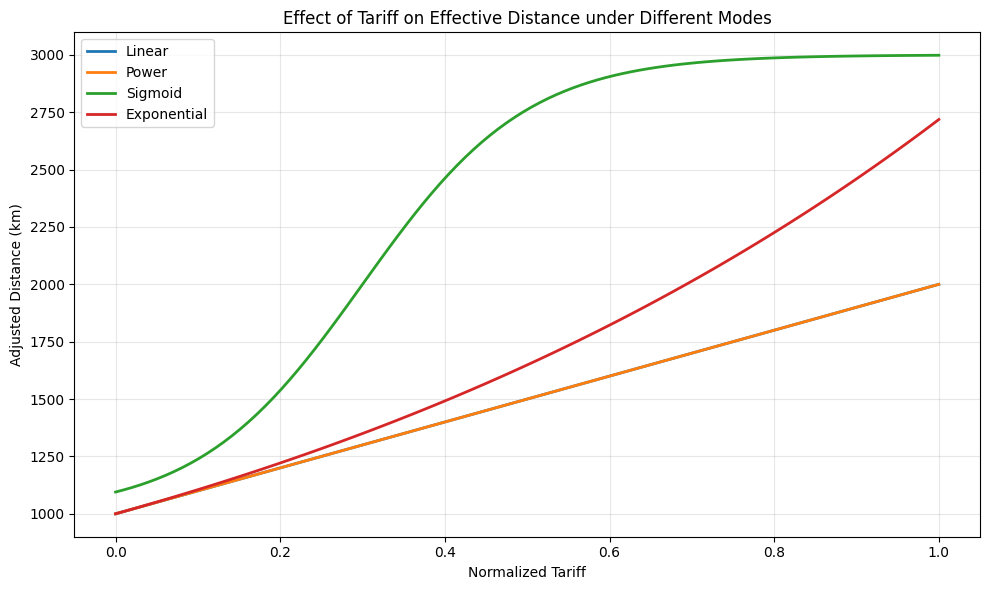

In [51]:
# Re-import required packages after code execution environment reset
import numpy as np
import matplotlib.pyplot as plt

# Simulated tariffs from 0 to 1 (normalized)
tariff_vals = np.linspace(0, 1, 100)
base_distance = 1000  # base distance in km

# Define adjustment modes
def adjusted_distance(tariff, mode, base_distance, alpha=1.0, a=2.0, b=10, c=0.3):
    if mode == "linear":
        return base_distance * (1 + tariff)
    elif mode == "power":
        return base_distance * (1 + tariff) ** alpha
    elif mode == "sigmoid":
        scale = 1 + a / (1 + np.exp(-b * (tariff - c)))
        return base_distance * scale
    elif mode == "piecewise":
        penalty = np.where(tariff < 0.1, 1.0,
                           np.where(tariff < 0.3, 1.2, 1.6))
        return base_distance * penalty
    else:  # exponential (default)
        return base_distance * np.exp(tariff)

# Compute adjusted distances for each mode
modes = ["linear", "power", "sigmoid", "exponential"]
adjusted = {mode: adjusted_distance(tariff_vals, mode, base_distance) for mode in modes}

# Plot
plt.figure(figsize=(10, 6))
for mode in modes:
    plt.plot(tariff_vals, adjusted[mode], label=mode.capitalize(), linewidth=2)

plt.title("Effect of Tariff on Effective Distance under Different Modes")
plt.xlabel("Normalized Tariff")
plt.ylabel("Adjusted Distance (km)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
